# Example ODE

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [62]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.training import train_deepmod, train_mse
from deepymod_torch.library_functions import library_1D_in

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(41)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we prepare the dataset.

In [107]:
def dU_dt(U, t):
    # Here U is a vector such that y=U[0] and z=U[1]. This function should return [y', z']
    return [U[1], -1*U[1] - 5*U[0]]
U0 = [1.8, 0.2]
ts = np.linspace(0, 10, 500)
Y = odeint(dU_dt, U0, ts)
T = ts.reshape(-1,1)

Let's plot it to get an idea of the data:

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [108]:
T_rs = T
Y_rs = Y/np.max(np.abs(Y),axis=0)

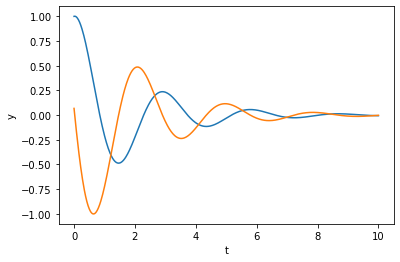

In [109]:
fig, ax = plt.subplots()
ax.plot(T_rs, Y_rs[:,0])
ax.plot(T_rs, Y_rs[:,1])
ax.set_xlabel('t')
ax.set_ylabel('y')

plt.show()

In [110]:
number_of_samples = 250

idx = np.random.permutation(Y.shape[0])
X_train = torch.tensor(T_rs[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(Y_rs[idx, :][:number_of_samples], dtype=torch.float32)

In [111]:
print(X_train.shape, y_train.shape)

torch.Size([250, 1]) torch.Size([250, 2])


## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [112]:
## Running DeepMoD
config = {'n_in': 1, 'hidden_dims': [20, 20, 20, 20, 20, 20], 'n_out': 2, 'library_function': library_1D_in, 'library_args':{'poly_order': 1, 'diff_order': 0}}

Now we instantiate the model:

In [113]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}])

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [78]:
train_deepmod(model, X_train, y_train, optimizer, 25000, {'l1': 1e-5})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   2.20e-04   1.22e-04   7.35e-05   2.53e-05 
[Parameter containing:
tensor([[1.6417]], requires_grad=True), Parameter containing:
tensor([[-3.0446]], requires_grad=True)]
[tensor([1]), tensor([2])]

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   8.31e-02   1.21e-04   8.30e-02   0.00e+00 

Now that DeepMoD has converged, it has found the following numbers:

In [85]:
solution = model(X_train)[0].detach().numpy()

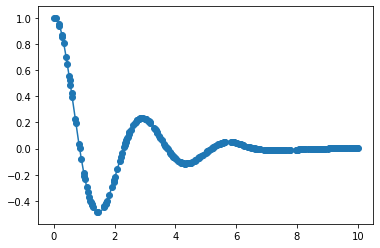

In [89]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,0])
plt.plot(T_rs,Y_rs[:,0])

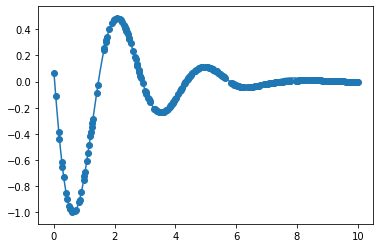

In [91]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,1])
plt.plot(T_rs,Y_rs[:,1])